In [1]:
import numpy as np
from IPython.display import Image
import json
import sqlite3
import ast
import photongraph as pg

See work by Vigliar et al for more details about postselected photonic graph state  generators https://arxiv.org/pdf/2009.08339.pdf

### Read in Graph State Recipe

In [2]:
conn = sqlite3.connect('graph_databases/graph_db_4P4D.db')
cursor = conn.cursor()

graph_hash = str(386485234)
cursor.execute("SELECT edge_dict, recipe_unitary FROM graphs WHERE graph_hash=" + graph_hash)
graph_record = cursor.fetchall()[0]
conn.close()

graph_recipe = json.loads(graph_record[1])
graph_edges = {ast.literal_eval(k):v for k, v in json.loads(graph_record[0]).items()}

### Graph State Recipe

In [3]:
graph_recipe

{'post_FLU': {'A': [['I', 'H'],
   ['I', 'I'],
   ['H', 'I'],
   ['S', 'I'],
   ['I', 'I']],
  'B': [['H', 'H'],
   ['I', 'I'],
   ['CZ_01'],
   ['I', 'H'],
   ['HS', 'SH'],
   ['Z', 'I']],
  'C': [['H', 'H'],
   ['I', 'I'],
   ['CZ_01'],
   ['H', 'H'],
   ['SH', 'SH'],
   ['H', 'I'],
   ['Z', 'I']],
  'D': [['H', 'H'],
   ['I', 'I'],
   ['CZ_01'],
   ['H', 'H'],
   ['SH', 'SH'],
   ['H', 'I'],
   ['Z', 'I']]},
 'Z_proj': {'1': 0, '0': 0}}

### Photonic Circuit Schematic

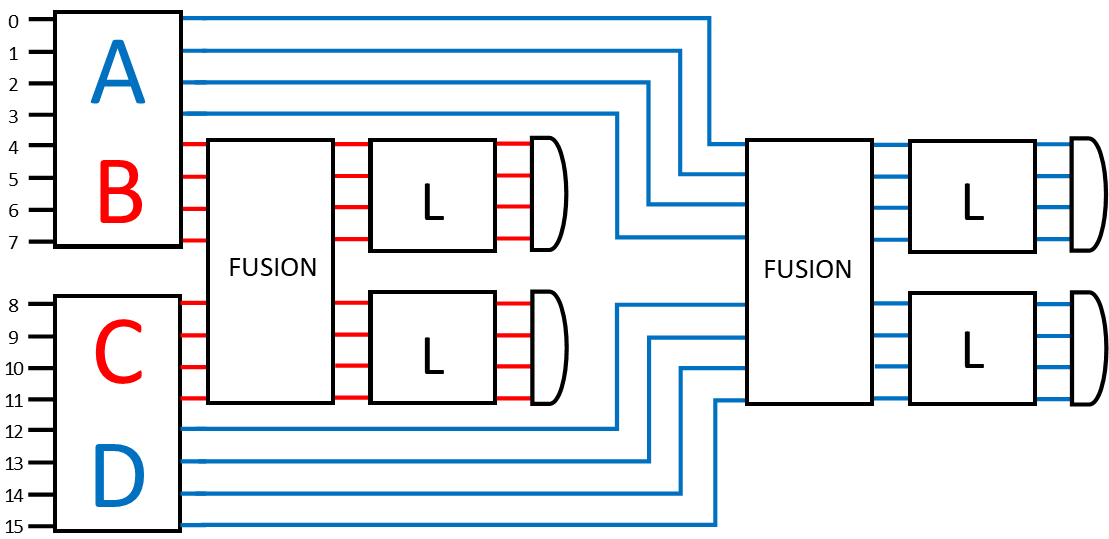

In [4]:
Image(filename = "PostGSG_4P4D.png", width=600, height=500)

### Configure Photonic Circuit

In [5]:
param_circ = pg.PostGSG4P4D()

qudit_dim = param_circ.qudit_dim

postFLU_A = pg.photonics.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['A'])
postFLU_B = pg.photonics.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['B'])
postFLU_C = pg.photonics.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['C'])
postFLU_D = pg.photonics.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['D'])
Z_projectors = graph_recipe['Z_proj']

param_circ.update_params(pg.photonics.decomp_inter(postFLU_A, 'postFLU_A'))
param_circ.update_params(pg.photonics.decomp_inter(postFLU_B, 'postFLU_B'))
param_circ.update_params(pg.photonics.decomp_inter(postFLU_C, 'postFLU_C'))
param_circ.update_params(pg.photonics.decomp_inter(postFLU_D, 'postFLU_D'))

In [6]:
sv = param_circ.run('qubit')
for q, s in Z_projectors.items():
    sv.measure_Z(int(q), int(s))

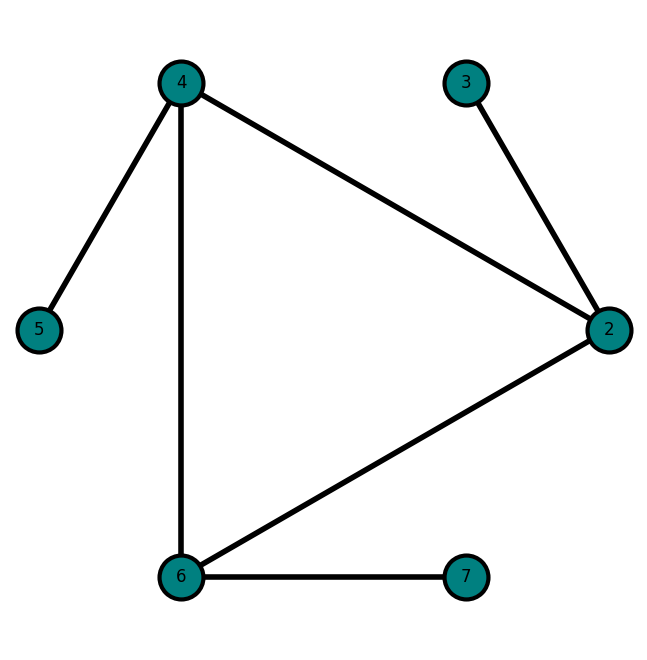

In [7]:
gs = pg.gs_from_sv(sv)
gs.draw()

### Check that circuit simulation gives the expected result

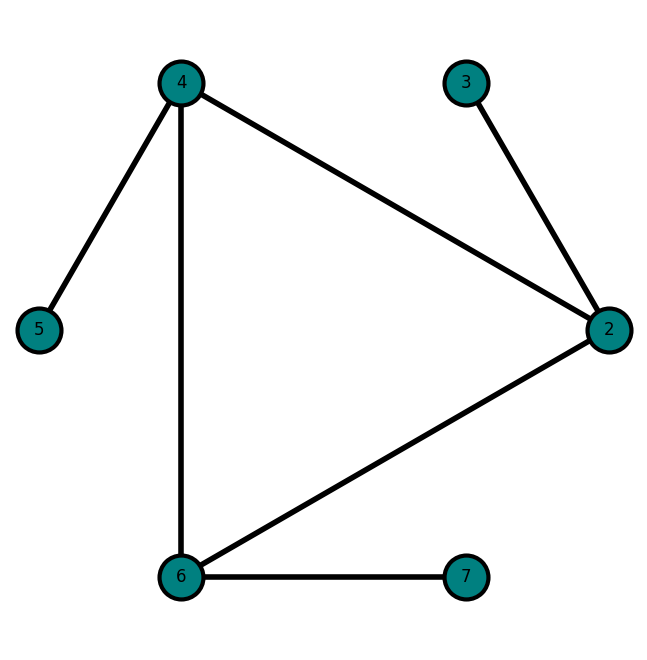

In [8]:
total_U = pg.utils.tensor(postFLU_A, postFLU_B, postFLU_C, postFLU_D)
vector_d2_n8_ghz = np.zeros(256, dtype='complex128')
vector_d2_n8_ghz[0] = 1
vector_d2_n8_ghz[-1] = 1
vector_d2_n8_ghz = 1 / np.sqrt(2) * vector_d2_n8_ghz
sv = pg.StateVector(8, 2, vector_d2_n8_ghz)
sv.evolve(total_U)
sv.measure_Z(0)
sv.measure_Z(1)
gs = pg.gs_from_sv(sv)
gs.draw()

### Estimate Coincidence Rate

In [9]:
# losses incurred per component in dB
component_losses = {"AMZI":1,
                    "crosser":0.2,
                    "grating_coupler":1.5,
                    "DC":0.0,
                    "MMI":0.5,
                    "off_chip_filter":2
                   }

# number of each component encounter on each mode
component_numbers = {"AMZI":1,
                    "crosser":8,
                    "grating_coupler":1,
                    "DC":0,
                    "MMI":8,
                    "off_chip_filter":1
                   }

# amount of propagation loss dB per cm
propagation_losses = {"chip":2.5,
                      "fibre":0.00002}

# propagation lenths in cm
propagation_lengths = {"chip":2.0,
                      "fibre":1500.0}

det_efficiency = 0.85

loss_params = {"component_losses": component_losses,
               "component_numbers": component_numbers,
               "propagation_losses": propagation_losses,
               "propagation_lengths": propagation_lengths,
               "det_efficiency": det_efficiency}


param_circ.coincidence_rate(loss_params)

'0.59954025 Hz'